In [3]:
%reset -f

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import pandas as pd
import cmath

from commpy.modulation import QAMModem, PSKModem

from optic.core import parameters
from optic.tx import simpleWDMTx
from optic.plot import pconst

from optic.models import linFiberCh, manakovSSF, ssfm, linFiberCh, awgn
from optic.models import phaseNoise, coherentReceiver, pdmCoherentReceiver, hybrid_2x4_90deg, pbs

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, pnorm
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power

import logging as logg
logg.getLogger().setLevel(logg.INFO)
logg.basicConfig(format='%(message)s')

In [5]:
import importlib.util

# Import OFE.py (Optical Front-End)
spec = importlib.util.spec_from_file_location("OFE", "../../utils/OFE.py")
OFE = importlib.util.module_from_spec(spec)
spec.loader.exec_module(OFE)

  0%|          | 0/1 [00:00<?, ?it/s]

channel 0	 fc : 193.1000 THz
  mode #0	 power: -3.01 dBm
  mode #1	 power: -3.01 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm


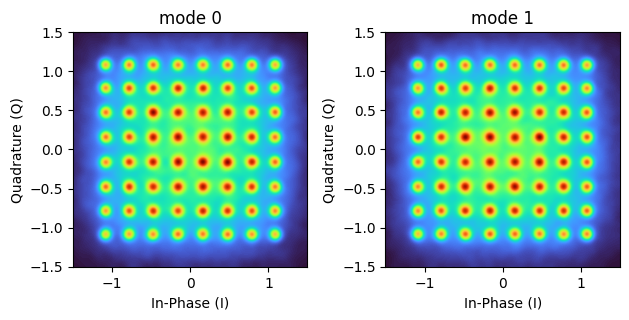

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: title={'center': 'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [6]:
# Parâmetros - Transmissor
paramTx = parameters()

paramTx.M   = 64             # Ordem do formato de modulação
paramTx.constType = 'qam'   # Formato de modulação ('qam' ou 'psk')

paramTx.Rs  = 100e9         # Taxa de sinalização [baud]
paramTx.SpS = 4             # Número de amostras por símbolo
Fs = paramTx.Rs*paramTx.SpS # Taxa de amostragem [Hz]

paramTx.Nbits = 300000      # Número total de bits por polarização

paramTx.pulse    = 'rrc'    # Tipo do filtro formatador de pulso
paramTx.Ntaps    = 1024     # Número de coeficientes do filtro
paramTx.alphaRRC = 0.01     # Rolloff do pulso RRC

paramTx.Pch_dBm  = 0        # Potência média por canal WDM [dBm]
paramTx.Nch      = 1        # Número de canais WDM

paramTx.Fc     = 193.1e12   # Frequência central de operação
paramTx.Nmodes = 2          # Número de modos de polarização

# gera sinal WDM
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)
pconst(sigWDM_Tx)

In [7]:
# Parâmetros - Canal Óptico
paramCh = parameters()

paramCh.Ltotal = 160       # Distância total do enlace [km]
paramCh.alpha = 0          # Parâmetro de perda da fibra [dB/km]
paramCh.D = 16             # Parâmetro de dispersão da fibra [ps/nm/km]
paramCh.Fc = paramTx.Fc    # Frequência central de operação [Hz]
paramCh.Fs = Fs            # Taxa de amostragem [Hz]

sigWDM = linFiberCh(sigWDM_Tx, paramCh.Ltotal, paramCh.alpha, paramCh.D, paramCh.Fc, paramCh.Fs)

In [8]:
# Potência do sinal recebido
try:
    potRx  = 10*np.log10( 1e3 * (signal_power(sigWDM[:,0]) + signal_power(sigWDM[:,1])) )
except:
    potRx  = 10*np.log10( 1e3 * signal_power(sigWDM))
print(f'Potência do sinal recebido: {potRx:.2f} dBm')

Potência do sinal recebido: 0.00 dBm


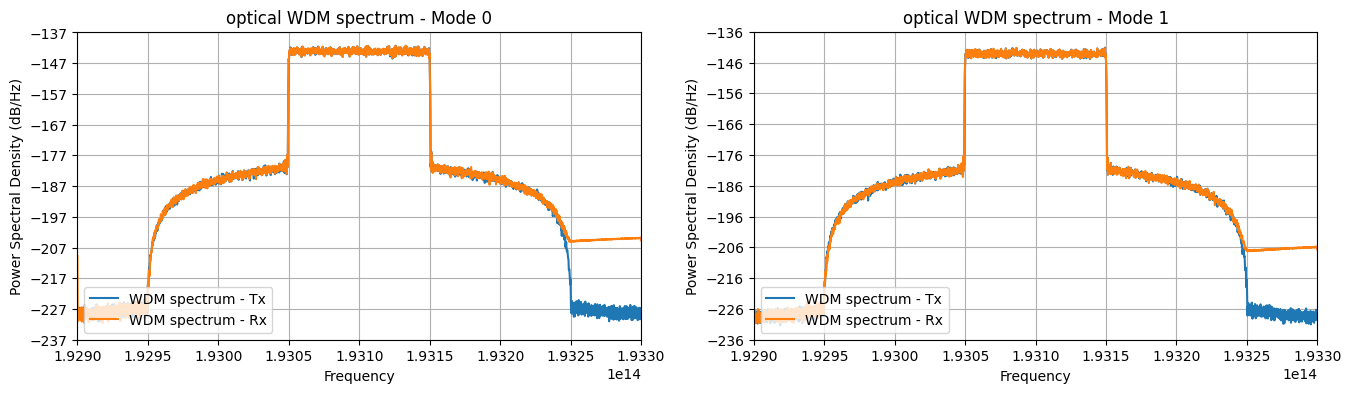

In [9]:
# plot psd
fig, axs = plt.subplots(1, 2, figsize=(16,4))

axs[0].psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramTx.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
axs[0].psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
axs[0].set_xlim(paramTx.Fc-Fs/2,paramTx.Fc+Fs/2)
axs[0].legend(loc='lower left')
axs[0].set_title('optical WDM spectrum - Mode 0')
axs[0].grid('True')

axs[1].psd(sigWDM_Tx[:,1], Fs=Fs, Fc=paramTx.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
axs[1].psd(sigWDM[:,1], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
axs[1].set_xlim(paramTx.Fc-Fs/2,paramTx.Fc+Fs/2)
axs[1].legend(loc='lower left')
axs[1].set_title('optical WDM spectrum - Mode 1')
axs[1].grid('True')

In [10]:
#############################################
# Parâmetros - Receptor
mod = QAMModem(m=paramTx.M)

chIndex  = 0     # Posição do canal WDM a ser demodulado
Fc = paramTx.Fc
Ts = 1/Fs

freqGrid = paramTx.freqGrid
print(f'Demodulating channel #{chIndex} \n',
      f'- fc: {((Fc + freqGrid[chIndex])/1e12):.4f} THz\n',
      f'- λ: {(const.c/(Fc + freqGrid[chIndex])/1e-9):.4f} nm\n')

symbTx = symbTx_[:,:,chIndex]

#############################################
# Parâmetros - Receptor - Oscilador Local
LOSPR   = 16                     # Relação potência do sinal-LO [dB]

π       = np.pi
FO      = 0*64e6                # Offset de frequência
Δf_lo   = freqGrid[chIndex]+FO  # Deslocamento de frequência do canal a ser demodulado
lw      = 0*100e3               # LineWidth
Plo_dBm = potRx + LOSPR         # Potência [dBm]
Plo     = 10**(Plo_dBm/10)*1e-3 # Potência [W]
ϕ_lo    = 0                     # Fase inicial [rad]    

print(f'Local oscillator\n',
      f'- Power: {Plo_dBm:.2f} dBm\n',
      f'- LOSPR: {LOSPR:.2f} dBm\n',
      f'- LineWidth: {(lw/1e3):.2f} kHz\n',
      f'- Frequency offset: {(FO/1e6):.2f} MHz')

#############################################
# Geração do sinal LO
t       = np.arange(0, len(sigWDM))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

Demodulating channel #0 
 - fc: 193.1000 THz
 - λ: 1552.5244 nm

Local oscillator
 - Power: 16.00 dBm
 - LOSPR: 16.00 dBm
 - LineWidth: 0.00 kHz
 - Frequency offset: 0.00 MHz


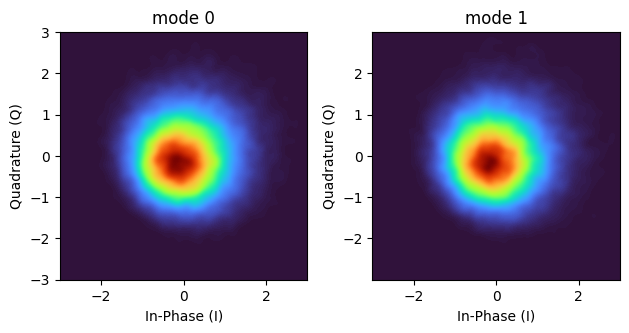

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: title={'center': 'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [11]:
# Receptor óptico single-ended
paramPD = parameters()
paramPD.B = 2 * paramTx.Rs
paramPD.Fs = Fs
paramPD.ideal = True

θsig = 0 # polarization rotation angle
R1_polx, R2_polx, R1_poly, R2_poly = OFE.pdmSEReceiver(sigWDM, sigLO, θsig=θsig, paramPD=paramPD)

sigPD_polx = R1_polx + 1j*R2_polx
sigPD_poly = R1_poly + 1j*R2_poly

sigPD      = np.array([sigPD_polx, sigPD_poly]).T
sigPD = sigPD - np.mean(sigPD)

sigRx = sigPD

# plot constellations (pós-receptor coerente)
pconst(sigRx[0::paramTx.SpS, :], lim=False, R=3)

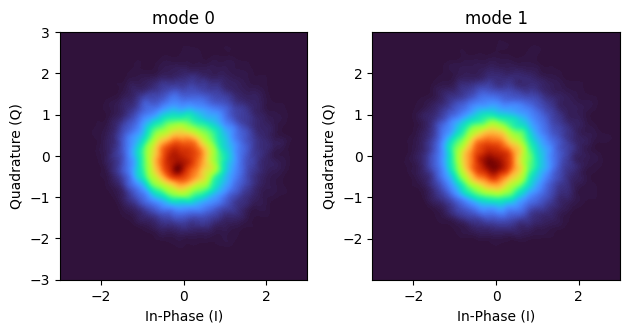

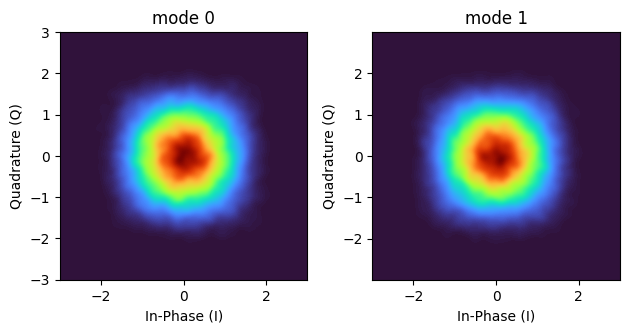

In [12]:
# Filtro casado
pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
pulse = pulse/np.max(np.abs(pulse))

sigRx = firFilter(pulse, sigRx)
    
# plot constellations (pós-filtragem)
pconst(sigRx[0::paramTx.SpS,:], R=3)

# Compensação da disperção cromática
if paramCh.Ltotal:
    sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fs)
    
    # plot constellations (pós-filtragem+compensação)
    pconst(sigRx[0::paramTx.SpS,:], R=3)

In [13]:
# Redução de amostras por símbolos
paramDec = parameters()

paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 2

sigRx = decimate(sigRx, paramDec)
symbRx = symbolSync(sigRx, symbTx, 2)

In [14]:
# Normalização do sinal
x = sigRx
d = symbRx

x = x.reshape(len(x),2)/np.sqrt(signal_power(x))
d = d.reshape(len(d),2)/np.sqrt(signal_power(d))

nlms - training stage #0
nlms pre-convergence training iteration #0
nlms MSE = 0.275626.
nlms pre-convergence training iteration #1
nlms MSE = 0.015608.
nlms pre-convergence training iteration #2
nlms MSE = 0.011748.
nlms pre-convergence training iteration #3
nlms MSE = 0.010499.
nlms pre-convergence training iteration #4
nlms MSE = 0.010086.
da-rde - training stage #1
da-rde MSE = 0.023495.


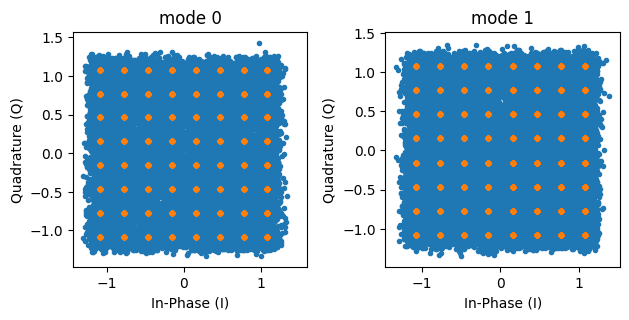

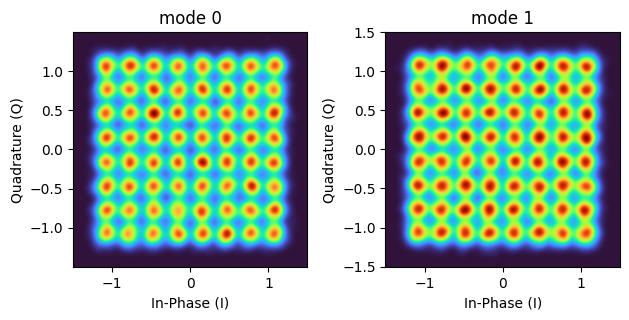

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: title={'center': 'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [15]:
# Algoritmo de Equalização
paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS   = 2
paramEq.mu    = [3e-3, 4e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg   = ['nlms','da-rde']
paramEq.M     = paramTx.M
paramEq.L = [int(0.20*len(x)/2), int(0.80*len(x)/2)]

paramEq.prgsBar = False
y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

# plot constellations (pós-equalização)
discard = 5000
pconst([y_EQ[discard:-discard,:],d[discard:-discard,:]], pType='fast')
pconst(y_EQ[discard:-discard,:])

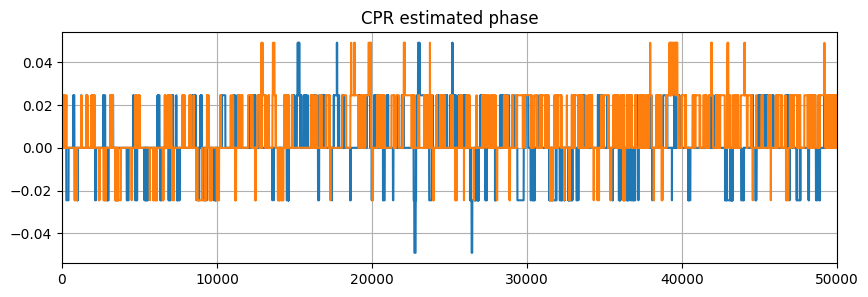

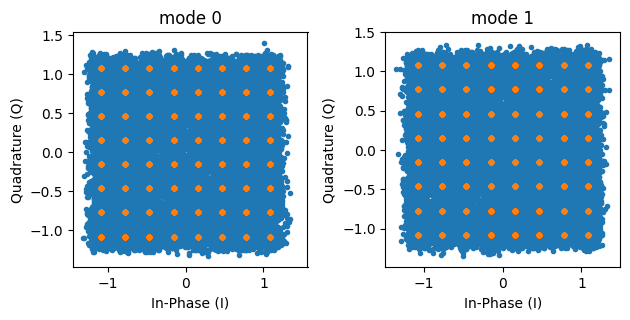

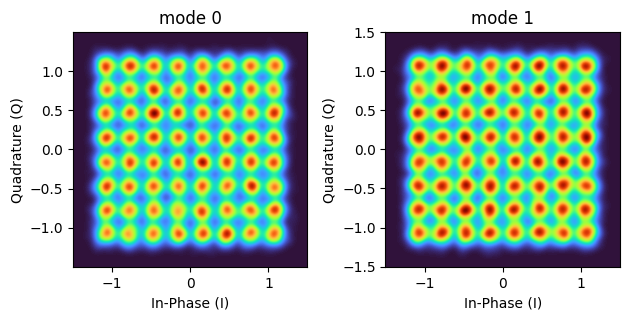

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: title={'center': 'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [16]:
# Algoritmo de Recuperação de Fase
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 160
paramCPR.B   = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20) 

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)
y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

plt.figure(figsize=(10, 3))
plt.title('CPR estimated phase')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid()

# plot constellations (pós-CPR)
discard = 5000
pconst([y_CPR[discard:-discard,:],d[discard:-discard,:]], pType='fast')
pconst(y_CPR[discard:-discard,:])

In [17]:
# métricas
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:,k]/y_CPR[:,k])
    y_CPR[:,k] = rot*y_CPR[:,k]

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))


ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
GMI,_    = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')

polx = [BER[0],SER[0],SNR[0],MI[0],GMI[0]]
poly = [BER[1],SER[1],SNR[1],MI[1],GMI[1]]
results = np.array([polx, poly])

df2 = pd.DataFrame(results, index=['Pol. X', 'Pol. Y'], columns=['BER', 'SER', 'SNR [dB]', 'GMI [bits]', 'MI [bits]'])
df2.style.format({"BER": "{:.2e}", "SER": "{:.2e}", "SNR [dB]": "{:.2f}", "GMI [bits]": "{:.2f}", "MI [bits]": "{:.2f}"})

,BER,SER,SNR [dB],GMI [bits],MI [bits]
Pol. X,1.18e-02,6.90e-02,19.55,5.73,5.73
Pol. Y,1.42e-02,8.31e-02,19.25,5.67,5.67
